# Intro to System ID

In [30]:
import numpy as np
from matplotlib import pyplot as plt
from ssid import system, markov, realize, ExtractModes
from control.matlab import ss
from control.matlab import lsim
from control.matlab import impulse as _impulse
def impulse(*args, **kwds):
    a,t = _impulse(*args, **kwds)
    return a.squeeze(),t

### SDOF Parameters
parameter | value
----------|-------
m  | mass
k  | stiffness
c  | damping coefficient
nt | number of timesteps
dt | timestep

![sdof](./figures/sdof.png)

In [98]:
# parameters of SDOF system
mass = m = 1           # mass
k = 100         # stiffness
zeta = 0.01     # damping ratio
omega_n = np.sqrt(k/m)  # natural frequency (rad/s)
c = 2*zeta*m*omega_n    # damping coefficient

# forcing frequencies (rad/s)
# omega_f = [0.017*omega_n, 0.14*omega_n, 0.74*omega_n]
omega_f = [0.011*omega_n, 0.18*omega_n, 0.7*omega_n]
# omega_f = [0.017*omega_n, 0.14*omega_n, 0.34*omega_n]
print(2*np.pi/omega_n)
print([2*np.pi/omega for omega in omega_f])

0.6283185307179586
[57.11986642890534, 3.4906585039886595, 0.8975979010256552]


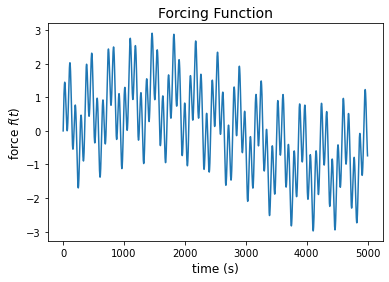

In [59]:
# forcing function
nt = 5000       # number of timesteps
dt = 0.03       # timestep
tf = nt*dt      # final time
t = np.arange(start = 0, stop = tf, step = dt)
f = np.sum(np.sin([omega*t for omega in omega_f]), axis=0)
plt.plot(f)
plt.xlabel("time (s)", fontsize=12)
plt.ylabel(r"force $f(t)$", fontsize=12)
plt.title("Forcing Function", fontsize=14);

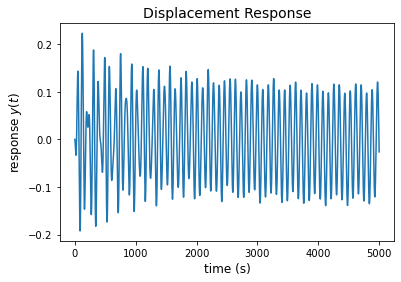

In [60]:
# displacement response (analytical solution)
omega_D = omega_n*np.sqrt(1-zeta**2)
y = np.zeros((3,nt))
for i,omega in enumerate(omega_f):
    C3 = (1/k)*(1-(omega/omega_n)**2)/((1-(omega/omega_n)**2)**2+(2*zeta*omega/omega_n))**2
    C4 = -(2*zeta*omega/omega_n)*(1-(omega/omega_n)**2)/((1-(omega/omega_n)**2)**2+(2*zeta*omega/omega_n))**2
    C1 = -C4
    C2 = (zeta*omega_n*C1-omega*C3)/omega_D
    y[i,:] = np.exp(-zeta*omega_n*t)*(C1*np.cos(omega_D*t)+C2*np.sin(omega_D*t)) + C3*np.sin(omega*t) + C4*np.cos(omega*t)
y = np.sum(y,axis=0)
plt.plot(y)
plt.xlabel("time (s)", fontsize=12)
plt.ylabel(r"response $y(t)$", fontsize=12)
plt.title("Displacement Response", fontsize=14);

In [99]:
if False:
    import sdof
    from quakeio.elcentro import accel as elcentro
    f = elcentro.data
    dt = elcentro["time_step"]
    t = np.arange(0, f.size*dt, dt)
    *_, y = sdof.integrate(mass,c,k,f,dt)

# System Identification

In [73]:
A,B,C,D = system.system(input=f, output=y)

KeyboardInterrupt: 

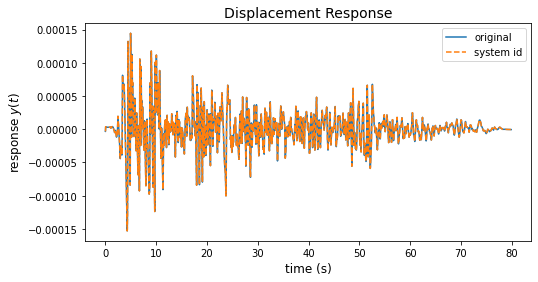

In [86]:
y_ssid = lsim(ss(A,B,C,D,dt),f,t)[0]
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(t,y,label="original")
ax.plot(t,y_ssid,"--",label=f"system id")
ax.set_xlabel("time (s)", fontsize=12)
ax.set_ylabel(r"response $y(t)$", fontsize=12)
ax.set_title("Displacement Response", fontsize=14)
ax.legend();

# Breakdown of System Identification Methods

### General Parameters
parameter | value
----------|-------
p  | number of output channels
q  | number of input channels
nt | number of timesteps
dt | timestep

### Specific to OKID
parameter | value
----------|-------
m  | number of Markov parameters to compute (at most = nt)

### Specific to ERA
parameter | value
----------|-------
no | number of observability parameters
nc | number of controllability parameters
r  | reduced model order

### Specific to DC
parameter | value
----------|-------
a  | (alpha) number of additional block rows in Hankel matrix of correlation matrices
b  | (beta) number of additional block columns in Hankel matrix of correlation matrices
l  | initial lag
g  | lag (gap) between correlations

### Specific to SRIM
parameter | value
----------|-------
ns | number of steps used for identification (prediction horizon)

In [100]:
p = 1
q = 1
m = 900
no = 425
nc = 425
r = 20
a = 0
b = 0
l = 10
g = 3
print(2*np.pi/omega_n)
print([2*np.pi/omega for omega in omega_f])

0.6283185307179586
[57.11986642890534, 3.4906585039886595, 0.8975979010256552]


In [77]:
# OKID-ERA

r_okid_era = 2
no = 1000
nc = 1000
m = 2050
Y = markov.okid(y, f, m)
A,B,C,D = realize.era(Y, no, nc, r=r_okid_era)
y_okid_era = lsim(ss(A,B,C,D,dt),f,t)[0]
modes = ExtractModes.modes(0.1, A, C)
print("period percent error:", [100*(1/(10*f)-2*np.pi/omega_n)/(2*np.pi/omega_n) for f in sorted([modes[str(i)]['freq'] for i in list(modes.keys())])])

period percent error: []


In [107]:
# OKID-ERA-DC

r_okid_era_dc = 2
# no = 1000
# nc = 1000
# m = 2050
Y = markov.okid(y, f, m)
A,B,C,D = realize.era_dc(Y, no, nc, a, b, l, g, r=r_okid_era_dc)
y_okid_era_dc = lsim(ss(A,B,C,D,dt),f,t)[0]
modes = ExtractModes.modes(0.1, A, C)
print([1/(5*f) for f in sorted([modes[str(i)]['freq'] for i in list(modes.keys())])])
print("period percent error:", [100*(1/(5*f)-2*np.pi/omega_n)/(2*np.pi/omega_n) for f in sorted([modes[str(i)]['freq'] for i in list(modes.keys())])])

[0.6304041254605024]
period percent error: [0.3319327125623103]


In [110]:
# SRIM

r_srim = 2
A,B,C,D = realize.srim(f, y, mro=nc, orm=r_srim)
y_srim = lsim(ss(A,B,C,D,dt),f,t)[0]
modes = ExtractModes.modes(0.1, A, C)
print([1/(5*f) for f in sorted([modes[str(i)]['freq'] for i in list(modes.keys())])])
print("period percent error:", [100*(1/(5*f)-2*np.pi/omega_n)/(2*np.pi/omega_n) for f in sorted([modes[str(i)]['freq'] for i in list(modes.keys())])])

[0.6304069567467769]
period percent error: [0.3323833257682116]


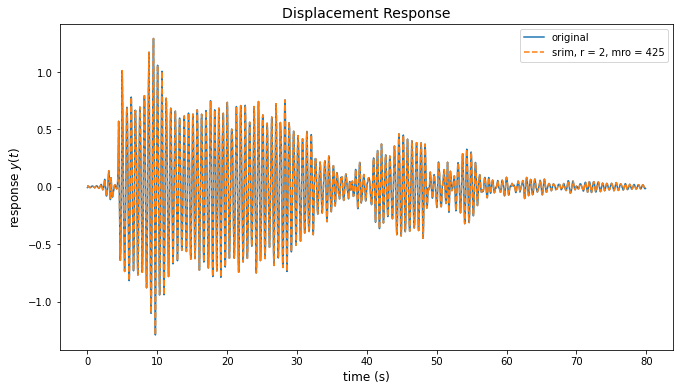

In [102]:
fig, ax = plt.subplots(figsize=(11,6))
ax.plot(t,y,label="original")
# ax.plot(t,y_okid_era,"--",label=f"okid-era, r = {r_okid_era}, {no=}, {nc=}, {m=}")
# ax.plot(t,y_okid_era_dc,"--",label=f"okid-era-dc, r = {r_okid_era_dc}, {no=}, {nc=}, {m=}, {a=}, {b=}, {l=}, {g=}")
ax.plot(t,y_srim,"--",label=f"srim, r = {r_srim}, mro = {nc}")
ax.set_xlabel("time (s)", fontsize=12)
ax.set_ylabel(r"response $y(t)$", fontsize=12)
ax.set_title("Displacement Response", fontsize=14)
ax.legend();